In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from altaipony.ffd import FFD

from funcs.flares import flare_factor
import astropy.units as u   

In [85]:
tessflares = pd.read_csv('../data/2022_07_flares_vetted.csv')
hip67522tess = tessflares[(tessflares["ID"] == "HIP 67522") & (tessflares["real"] == 1) & (tessflares["mask_pos_outliers_sigma"] > 1.5)]
# hip67522tess = hip67522tess[hip67522tess["phase"] < 0.1]
hip67522tess

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,...,TIC,qcs,mission,tstamp,lc_n,w,mask_pos_outliers_sigma,real,note,helpid
3822,5677.0,5685.0,274195.0,274203.0,1608.286861,1608.297972,2.355643,0.189734,0.003271,0.011111,...,166527623,11,TESS,2022_07_30,1.0,61.0,2.5,1.0,NaN,HIP 67522_TESS_11
3823,6675.0,6686.0,275193.0,275204.0,1609.672965,1609.688243,6.089314,0.248886,0.008170,0.015278,...,166527623,11,TESS,2022_07_30,1.0,61.0,2.5,1.0,NaN,HIP 67522_TESS_11
3824,512.0,522.0,797352.0,797362.0,2334.893506,2334.907395,3.589193,0.323217,0.005232,0.013889,...,166527623,38,TESS,2022_07_30,2.0,61.0,2.5,1.0,NaN,HIP 67522_TESS_38
3825,571.0,590.0,797411.0,797430.0,2334.975450,2335.001839,16.116874,0.054201,0.011215,0.026389,...,166527623,38,TESS,2022_07_30,2.0,61.0,2.5,1.0,NaN,HIP 67522_TESS_38
3826,711.0,719.0,797551.0,797559.0,2335.169895,2335.181006,2.889699,0.203887,0.005448,0.011111,...,166527623,38,TESS,2022_07_30,2.0,61.0,2.5,1.0,NaN,HIP 67522_TESS_38
3827,5628.0,5635.0,802477.0,802484.0,2342.011543,2342.021265,3.509081,0.175693,0.005248,0.009722,...,166527623,38,TESS,2022_07_30,2.0,61.0,2.5,1.0,NaN,HIP 67522_TESS_38
16357,1014.0,1018.0,1307014.0,1307018.0,3042.756663,3042.762219,1.348630,0.135588,0.003605,0.005556,...,166527623,64,TESS,2023_06_05,0.0,59.0,2.0,1.0,NaN,HIP 67522_TESS_64
16358,2110.0,2119.0,1308110.0,1308119.0,3044.278934,3044.291435,2.408769,0.154815,0.003952,0.012500,...,166527623,64,TESS,2023_06_05,0.0,59.0,2.0,1.0,NaN,HIP 67522_TESS_64
16359,2934.0,2941.0,1308934.0,1308941.0,3045.423414,3045.433137,1.570411,0.148194,0.002882,0.009723,...,166527623,64,TESS,2023_06_05,0.0,59.0,2.0,1.0,NaN,HIP 67522_TESS_64
16360,8227.0,8234.0,1314381.0,1314388.0,3052.988894,3052.998616,2.067852,0.178716,0.003541,0.009722,...,166527623,64,TESS,2023_06_05,0.0,59.0,2.0,1.0,NaN,HIP 67522_TESS_64


In [86]:
   # read TESS response function
tess_resp = pd.read_csv("../data/tess-response-function-v2.0.csv", skiprows=7, names=["wav", "resp"], header=None)
wav, resp = tess_resp.wav.values, tess_resp.resp.values
# cheops_resp = pd.read_csv("../data/CHEOPS_bandpass.csv",)
# wav, resp = cheops_resp.WAVELENGTH.values, cheops_resp.THROUGHPUT.values

# sample the posterior distribution of the flare energy using the MCMC samples on ED, and teff and radius with Gaussian errors
teff = np.random.normal(5650, 75, 500)
radius = np.random.normal(1.392, 0.05, 500)


def get_flare_energy(ed, ederr, teff, radius, wav, resp):
    # sample the posterior distribution of the flare energy using the MCMC samples on ED, and teff and radius with Gaussian errors
    teff = np.random.normal(5650, 75, 500)
    radius = np.random.normal(1.392, 0.05, 500)
    eds = np.random.normal(ed, ederr, 500)
    # calculate the bolometric flare energy for each sample
    bol_energies = (flare_factor(teff.reshape((500,1)), radius.reshape((500,1)), wav, resp,  tflare=10000) * np.random.choice(eds, 500) * u.s).value

    # calculate the mean and standard deviation of the bolometric flare energy
    mean_bol_energy = np.mean(bol_energies)
    std_bol_energy = np.std(bol_energies)

    return mean_bol_energy, std_bol_energy

res = hip67522tess.apply(lambda x: get_flare_energy(x["ed_rec"], x["ed_rec_err"], teff, radius, wav, resp), axis=1)

# write res to two columns in a new dataframe
hip67522tessffd = pd.DataFrame(res.values.tolist(), columns=["ed_rec", "ed_rec_err"])   
hip67522tessffd["phase"] = hip67522tess["phase"].values

obs_time_d_tess = hip67522tess["total_n_valid_data_points"].unique() * 2.0 / 60.0 / 24.0
tot_obs_time_d_tess = obs_time_d_tess.sum()


tot_obs_time_d_tess = 6.85
print(f"Total TESS observation time in days: {tot_obs_time_d_tess}")



Total TESS observation time in days: 6.85


,ed_rec,ed_rec_err,phase
0,6.494167e+33,8.874449e+32,0.955230
1,1.490604e+34,1.574569e+33,0.055400
2,7.558613e+34,6.622868e+33,0.061496
3,7.309389e+35,6.966037e+34,0.024634
0,8.137598e+33,9.381562e+32,0.612565
1,2.106029e+34,1.945166e+33,0.811733
2,1.246642e+34,1.551314e+33,0.017527
3,5.569968e+34,4.777212e+33,0.029302
4,1.007997e+34,1.122592e+33,0.057241
5,1.217223e+34,1.305945e+33,0.040307


In [87]:
cheopsflares = pd.read_csv('../results/cheops_flares.csv')
cheopsflares["ed_rec"] = cheopsflares["mean_bol_energy"].values
cheopsflares["ed_rec_err"] = cheopsflares["std_bol_energy"].values
cheopsflares.ed_rec = cheopsflares.ed_rec.apply(lambda x: float(x[:-4]))
cheopsflares.ed_rec_err = cheopsflares.ed_rec_err.apply(lambda x: float(x[:-4]))
cheopsflares

,date,newmed,amplitude,t_peak_BJD,dur_d,amplitude2,t_peak_BJD2,dur_d2,ED,EDerr,mean_bol_energy,std_bol_energy,ingress,egress,tmin,tmax,parametrization,tot_obs_time_d,ed_rec,ed_rec_err
0,20240415114752,2.463032e+06,4188.419774,2.460413e+06,0.030912,NaN,NaN,NaN,2.09,0.233,6.494166996961426e+33 erg,8.874449071302292e+32 erg,2.460413e+06,NaN,2460413.175,2460413.20,davenport2014,0.174306,6.494167e+33,8.874449e+32
1,20240529072301,2.492243e+06,9879.207629,2.460456e+06,0.021951,NaN,NaN,NaN,4.86,0.296,1.4906041750484522e+34 erg,1.5745692283025478e+33 erg,NaN,2.460455e+06,2460455.630,2460455.67,davenport2014,0.300347,1.490604e+34,1.574569e+33
2,20240410135336,2.565071e+06,31787.034053,2.460400e+06,0.028275,NaN,NaN,NaN,24.60,0.583,7.558613035634906e+34 erg,6.622868258540838e+33 erg,NaN,2.460400e+06,2460399.970,2460400.09,davenport2014,0.321875,7.558613e+34,6.622868e+33
3,20240325102059,2.522340e+06,130290.487307,2.460393e+06,0.054068,138748.127497,2.460393e+06,0.010392,236.00,9.420,7.309389286702922e+35 erg,6.9660371380047725e+34 erg,NaN,2.460393e+06,2460392.760,2460392.93,davenport2014,0.317940,7.309389e+35,6.966037e+34


In [88]:
import glob
from astropy.io import fits 

files = glob.glob('../data/hip67522/CHEOPS-products-*/Outdata/00000/hip67522_CHEOPS-products-*_im.fits')
time = np.array([])
flux = np.array([])
cheopsphases = np.array([])

midpoint = 2460392.61598
period = 6.959503

for file in files:
    hdulist = fits.open(file)


    # get the image data
    image_data = hdulist[1].data

    t, f, ferr, roll = image_data["BJD_TIME"], image_data["FLUX"], image_data["FLUXERR"], image_data["ROLL"]

    # make sure the data is in fact 10s cadence
    assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Time series is not 10s cadence"

    # big endian to little endian
    t = t.byteswap().newbyteorder()
    f = f.byteswap().newbyteorder()
    ferr = ferr.byteswap().newbyteorder()
    roll = roll.byteswap().newbyteorder()

    time = np.concatenate([time, t])
    flux = np.concatenate([flux, f])
    cheopsphases = np.concatenate([cheopsphases, ((t - midpoint) % period) / period])

tot_obs_time_d_cheops = len(time) * 10. / 60. / 60. / 24.
print(f"Total CHEOPS observation time in days: {tot_obs_time_d_cheops}")    


tcheops01 = len(time[cheopsphases < 0.1]) * 10. / 60. / 60. / 24.
tcheops09 = len(time[cheopsphases > 0.1]) * 10. / 60. / 60. / 24.

tcheops01, tcheops09, tot_obs_time_d_cheops


Total CHEOPS observation time in days: 6.825


(4.68912037037037, 2.1358796296296294, 6.825)

In [29]:
tessffd = FFD(f=hip67522tessffd, tot_obs_time=tot_obs_time_d_tess, ID="HIP 67522")
cheopsffd = FFD(f=cheopsflares, tot_obs_time=tot_obs_time_d_cheops, ID="HIP 67522")
cheopsflares.amplitude/cheopsflares.newmed
cheopsflares.dur_d

0    0.030912
1    0.021951
2    0.028275
3    0.054068
Name: dur_d, dtype: float64

Setting ED with new values, size 12.
Setting frequency values with new values, size 12.
Setting frequency adjusted count values with new values, size 12.
Setting ED with new values, size 4.
Setting frequency values with new values, size 4.
Setting frequency adjusted count values with new values, size 4.


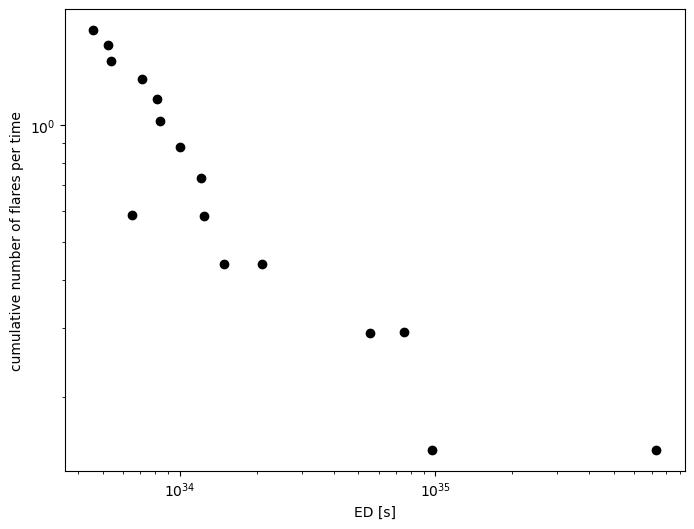

In [30]:
plt.figure(figsize=(8, 6))
for ffd in [tessffd, cheopsffd]:
    ed, freq, counts = ffd.ed_and_freq()
    # print(ed, freq, counts)
    plt.scatter(ed, freq, c="k")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("ED [s]")
plt.ylabel("cumulative number of flares per time");


In [65]:
# get the cheops phase
midpoint = 2460392.61598
period = 6.959503

cheopsflares["phase"] = ((cheopsflares["t_peak_BJD"] - midpoint) % period) / period

# make a DataFrame with the cheops and tess flare energies and phases
df = pd.concat([cheopsflares[["ed_rec", "ed_rec_err", "phase"]], hip67522tessffd[["ed_rec", "ed_rec_err", "phase"]]])
df


,ed_rec,ed_rec_err,phase
0,6.494167e+33,8.874449e+32,0.955230
1,1.490604e+34,1.574569e+33,0.055400
2,7.558613e+34,6.622868e+33,0.061496
3,7.309389e+35,6.966037e+34,0.024634
0,8.137598e+33,9.381562e+32,0.612565
1,2.106029e+34,1.945166e+33,0.811733
2,1.246642e+34,1.551314e+33,0.017527
3,5.569968e+34,4.777212e+33,0.029302
4,1.007997e+34,1.122592e+33,0.057241
5,1.217223e+34,1.305945e+33,0.040307


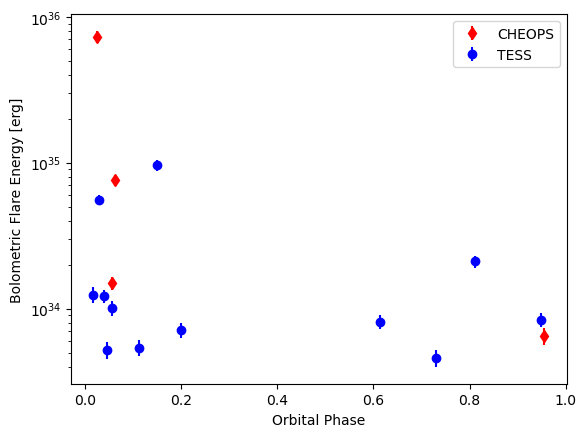

In [62]:
plt.errorbar(cheopsflares["phase"], cheopsflares["ed_rec"], yerr=cheopsflares['ed_rec_err'], c="r", label="CHEOPS", fmt="d" )
plt.errorbar(hip67522tessffd["phase"], hip67522tessffd["ed_rec"], yerr = hip67522tessffd["ed_rec_err"], c="b", label="TESS", fmt="o")
plt.legend()
plt.yscale("log")
plt.xlabel("Orbital Phase")
plt.ylabel("Bolometric Flare Energy [erg]");

Setting ED with new values, size 8.
Setting frequency values with new values, size 8.
Setting frequency adjusted count values with new values, size 8.
/home/ilin/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/ilin/anaconda3/lib/python3.11/site-packages/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 500/500 [00:01<00:00, 296.52it/s]
Setting ED with new values, size 8.
Setting frequency values with new values, size 8.
Setting frequency adjusted count values with new values, size 8.
100%|██████████| 500/500 [00:01<00:00, 344.40it/s]


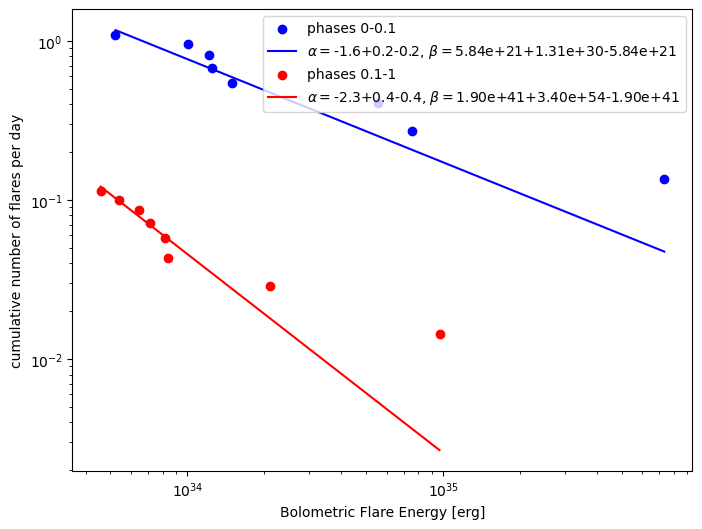

In [72]:
# df = hip67522tessffd
df10 = df[df["phase"]<0.1]
df90 = df[df["phase"]>0.1]
obs10 =  ttess01 #tcheops01 + 
obs90 =  ttess09 # tcheops09 + 

ffd10 = FFD(f=df10, tot_obs_time=obs10, ID="phases 0-0.1")
ffd90 = FFD(f=df90, tot_obs_time=obs90, ID="phases 0.1-1")

color = ["b", "r"]

fig, ax = plt.subplots(figsize=(8, 6))
alphas, betas = [], []
alphas_up, alphas_low = [], []
betas_up, betas_low = [], []
for ffd, c in list(zip([ffd10, ffd90], color)):
    ed, freq, counts = ffd.ed_and_freq()
    ax.scatter(ed, freq, c=c, label=ffd.ID)

    # fit power law to each
    
    ffd.fit_powerlaw("mcmc")
    ffd.plot_powerlaw(ax, c=c, label=fr'$\alpha=$-{ffd.alpha:.1f}+{ffd.alpha_up_err:.1f}-{ffd.alpha_low_err:.1f}')
    alphas.append(ffd.alpha)
    betas.append(ffd.beta)
    alphas_up.append(ffd.alpha_up_err)
    alphas_low.append(ffd.alpha_low_err)
    betas_up.append(ffd.beta_up_err)
    betas_low.append(ffd.beta_low_err)
    
plt.xscale("log")   
plt.yscale("log")
plt.xlabel("Bolometric Flare Energy [erg]")
plt.ylabel("cumulative number of flares per day");
plt.legend()

(array([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 4., 4., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
        0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
        0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
        0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
        0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ]),
 <BarContainer object of 24 artists>)

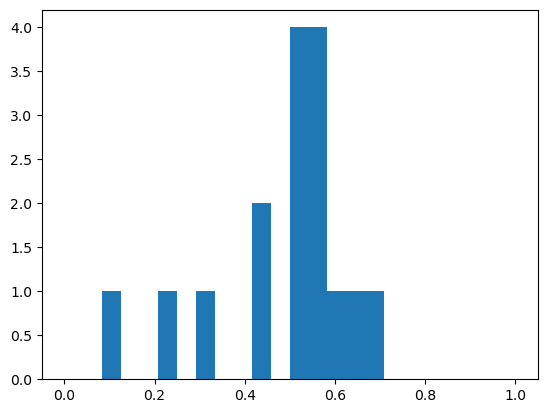

In [83]:
plt.hist((df["phase"] + 0.5) % 1, bins=np.linspace(0,1,25))

In [67]:
flum10 = df10.ed_rec.sum()/(ttess01 + tcheops01) / 24. / 60 / 60
flum90 = df90.ed_rec.sum()/ (ttess09 + tcheops09)  / 24. / 60 / 60
flum10err = np.sqrt((df10.ed_rec_err**2).sum())/(ttess01 + tcheops01) / 24. / 60 / 60
flum90err = np.sqrt((df90.ed_rec_err**2).sum())/(ttess09 + tcheops09) / 24. / 60 / 60

print(f"Flare luminosity in phases 0-0.1: {flum10:.2e} +/- {flum10err:.2e} erg/s")
print(f"Flare luminosity in phases 0.1-1: {flum90:.2e} +/- {flum90err:.2e} erg/s")

Flare luminosity in phases 0-0.1: 9.19e+28 +/- 5.14e+27 erg/s
Flare luminosity in phases 0.1-1: 2.44e+28 +/- 1.40e+27 erg/s


In [92]:
import lightkurve as lk
lcs = lk.search_lightcurvefile("HIP 67522", mission="TESS",author="SPOC", exptime=120)
lcs

/tmp/ipykernel_105313/2696015668.py:2: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lcs = lk.search_lightcurvefile("HIP 67522", mission="TESS",author="SPOC", exptime=120)


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 11,2019,SPOC,120,166527623,0.0
1,TESS Sector 38,2021,SPOC,120,166527623,0.0
2,TESS Sector 64,2023,SPOC,120,166527623,0.0


In [93]:
midpoints = [2458694.49725,2459425.24506,2460155.99288]

lcs = [lc.download() for lc in lcs]

# get all phases for the TESS light curves
tessphases = []
for lc, midpoint in zip(lcs, midpoints):
    tessphases.append(((lc.time.value - midpoint) % period) / period)

tessphases = np.concatenate(tessphases)

# get the observing time for first 10% and last 90% of the light curve
ttess01 = len(tessphases[tessphases < 0.1]) * 2. / 60. / 24.
ttess09 = len(tessphases[tessphases > 0.1]) * 2. / 60. / 24.

ttess = ttess01 + ttess09
ttess01, ttess09, ttess

3% (562/18749) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
3% (562/18749) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
0% (41/18535) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
0% (41/18535) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
0% (80/18934) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
0% (80/18934) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


(7.3625, 69.76944444444445, 77.13194444444444)

In [94]:
cheopsphases, tessphases

(array([0.01439838, 0.01441505, 0.01443172, ..., 0.81463956, 0.81465623,
        0.8146729 ]),
 array([0.50808923, 0.5082888 , 0.50848837, ..., 0.90980245, 0.91000202,
        0.91020158]))

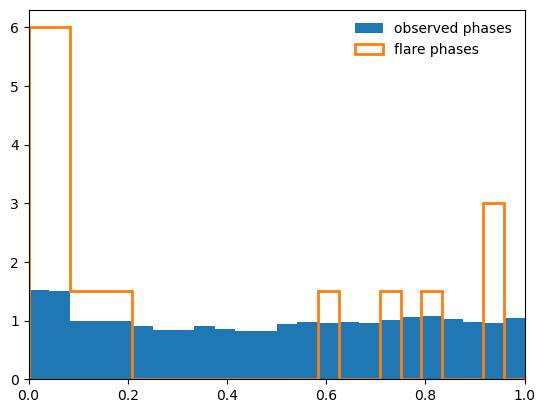

In [104]:
phases = np.concatenate([cheopsphases, tessphases])
weights = np.concatenate([np.ones_like(cheopsphases) / 6., np.ones_like(tessphases) * 2])

plt.hist(phases, bins=np.linspace(0,1,25), weights=weights, density=True, label="observed phases")
plt.hist(df["phase"], bins=np.linspace(0,1,25), histtype="step", lw=2, density=True, label="flare phases")
plt.xlim(0,1)
plt.legend(frameon=False)

In [113]:
hist, bins = np.histogram(phases, bins=np.linspace(0,1,25), weights=weights)

samples = np.array([np.random.choice(bins[:-1], 16, p=hist/hist.sum()) for _ in range(10000)])

(0.0, 1.0)

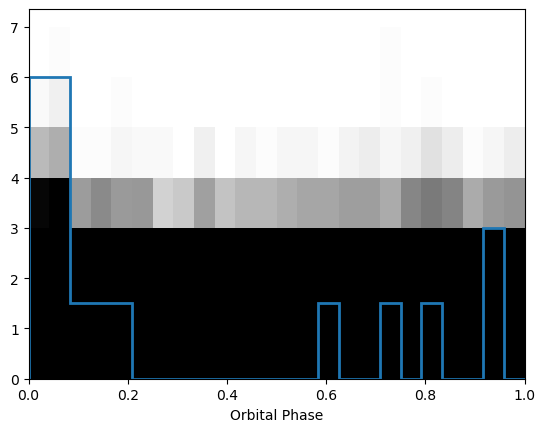

In [114]:
for sample in samples:
    plt.hist(sample, bins=bins,  lw=0.1, color="k", alpha=0.01)
plt.hist(df["phase"], bins=np.linspace(0,1,25), histtype="step", lw=2, density=True, label="flare phases")
plt.xlabel("Orbital Phase")
plt.xlim(0,1)